In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/New Plant Diseases Dataset(Augmented).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/folder')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [ ]:
# EDA

len(os.listdir("/content/folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"))

38

In [ ]:
train_datagen = ImageDataGenerator(zoom_range = 0.5, shear_range = 0.3, horizontal_flip = True, preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
train = train_datagen.flow_from_directory(directory = "/content/folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         target_size = (256, 256),
                                         batch_size = 32)

val = val_datagen.flow_from_directory(directory = "/content/folder/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                         target_size = (256, 256),
                                         batch_size = 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
t_img, label = train.next()

In [ ]:
def plotImage(img_arr, label) :
    for im , l in zip(img_arr, label) :
        plt.figure(figsize = (5, 5))
        plt.imshow(im/255)
        plt.show()

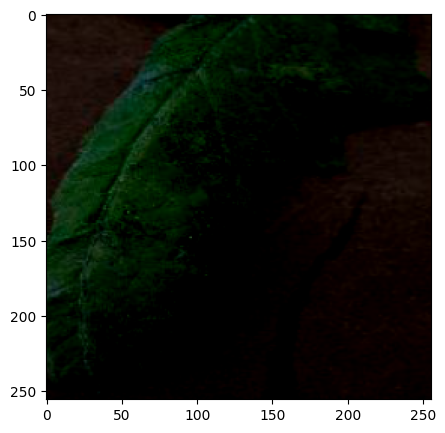

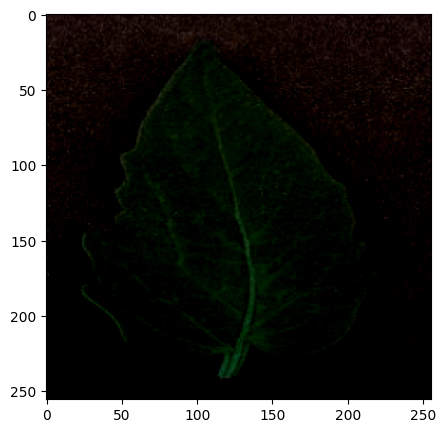

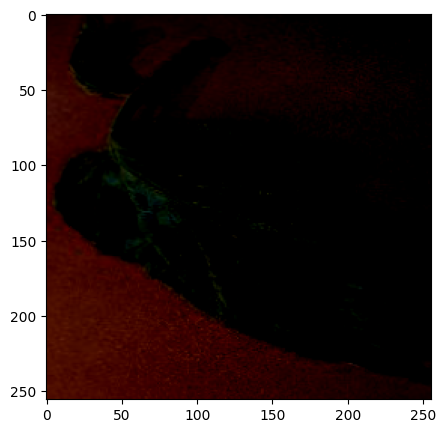

In [ ]:
plotImage(t_img[:3], label[:3])

#Building our model


In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [ ]:
base_model = VGG19(input_shape = (256, 256, 3), include_top = False)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers :
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
X = Flatten()(base_model.output)

X = Dense(units = 38, activation = 'softmax')(X)

#Creating our model

model = Model(base_model.input, X)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

#Early stopping and Model Check point

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose = 1)

mc = ModelCheckpoint(filepath = "best_model.h5",
                     monitor = 'val_accuracy',
                     min_delta = 0.01,
                     patience = 3,
                     verbose = 1,
                     save_best_only = True)

cb = [es, mc]

In [ ]:
his = model.fit(train,
                          steps_per_epoch = 16,
                          epochs = 50,
                          verbose = 1,
                          callbacks = cb,
                          validation_data = val,
                          validation_steps = 16)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 29.7830 - accuracy: 0.1523
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to best_model.h5
16/16 [==============================] - 27s 824ms/step - loss: 29.7830 - accuracy: 0.1523 - val_loss: 18.0475 - val_accuracy: 0.4062
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 14.4760 - accuracy: 0.4395
Epoch 2: val_accuracy improved from 0.40625 to 0.50000, saving model to best_model.h5
16/16 [==============================] - 14s 857ms/step - loss: 14.4760 - accuracy: 0.4395 - val_loss: 11.8271 - val_accuracy: 0.5000
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 13.9847 - accuracy: 0.4883
Epoch 3: val_accuracy improved from 0.50000 to 0.67188, saving model to best_model.h5
16/16 [==============================] - 16s 1s/step - loss: 13.9847 - accuracy: 0.4883 - val_loss: 6.3723 - val_accuracy: 0.6719
Epoch 4/50
16/16 [==============================] - ETA: 0s - 

In [ ]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

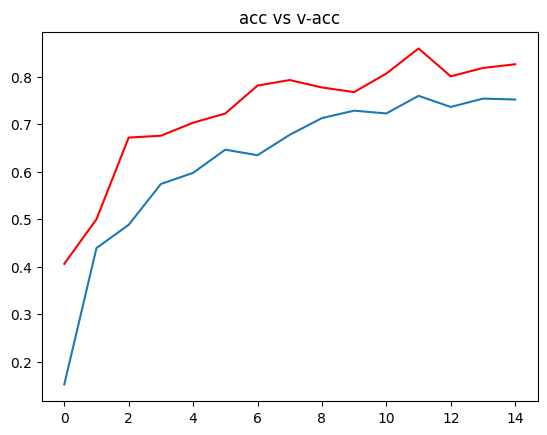

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title("acc vs v-acc")
plt.show()

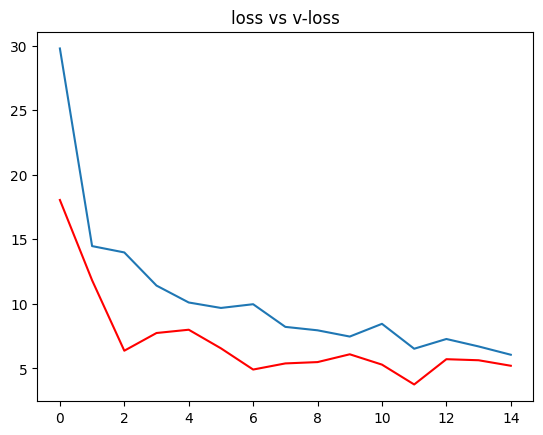

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title("loss vs v-loss")
plt.show()

#Load Best Model

In [ ]:
from keras.models import load_model

model = load_model("/content/best_model.h5")

In [ ]:
acc = model.evaluate(val)[1]

print(f"The accuracy of your model is = {acc * 100} %")

550/550 [==============================] - 115s 209ms/step - loss: 4.3102 - accuracy: 0.8276
The accuracy of your model is = 82.76234865188599 %


In [ ]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())  )  )

In [ ]:
def prediction(path) :
  img = load_img(path, target_size = (256, 256))

  i = img_to_array(img)

  im = preprocess_input(i)

  img = np.expand_dims(im, axis = 0)

  pred = np.argmax(model.predict(img) )

  print(f"The image belongs to { ref[pred] }")

In [ ]:
path = "/content/folder/New Plant Diseases Dataset(Augmented)/test/test/PotatoEarlyBlight1.JPG"

prediction(path)

1/1 [==============================] - 0s 65ms/step
The image belongs to Potato___Early_blight
